In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code')
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import json
from PIL import Image
import random
import pickle
import matplotlib.pyplot as plt
from helpers import m
import cv2
import sys
from _external_classification.train import train_one_epoch
from helpers.dataset_evaluation import print_class_distribution

In [2]:
test_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\tank 3 data\\balanced_data_full\\data'
#test_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\tank 9 data\\test data\\balanced_data'

In [3]:
class salmonToraxDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = torchvision.transforms.ToTensor()
        self.imgs = list(sorted(os.listdir(os.path.join(path, 'images'))))
        self.targets = list(sorted(os.listdir(os.path.join(path, 'labels'))))
        self.path = path
        
    def __getitem__(self, idx):
        
        with open(os.path.join(self.path, 'labels', self.targets[idx])) as f:
            label = json.load(f)
        img = Image.open(os.path.join(self.path, 'images', self.imgs[idx]))
        
        img_tensor = torchvision.transforms.functional.pil_to_tensor(img)
        img_tensor = torch.div(img_tensor, 255)
        img_tensor = img_tensor.to(m.DEVICE)
        return img_tensor, label

    def __len__(self):
        return len(self.imgs)

In [4]:
test_dataset = salmonToraxDataset(test_path)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=m.BATCH_SIZE, shuffle=True)

In [5]:
classes = ['background', 'Abiezer_sl', 'Abiezer_sr', 'Berachiah_sl', 'Berachiah_sr', 'Chimham_sl', 'Chimham_sr', 'Dathan_sl', 'Dathan_sr', 'Eliah_sl', 'Eliah_sr', 'Gemariah_sl', 'Gemariah_sr', 'Habakkuk_sl', 'Habakkuk_sr']
#classes = m.CLASSES_T9
model = torchvision.models.resnet101(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=len(classes))
model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\salmon_torax_ID (46)', map_location=m.DEVICE))
data_loader = data_loader_test
model.to(m.DEVICE).eval()

c:\Users\espebh\Documents\Thesis\code\dat_gen_th\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\espebh\Documents\Thesis\code\dat_gen_th\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
import torch.nn as nn
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

res = []
y_pred = []
y_true = []
err_img = []
err_pred = []

for d, t in data_loader:
   if d.shape[0] == m.BATCH_SIZE:
       pred = model(d)
       pred_np = softmax(pred.detach().cpu().numpy(), axis=1)
       c = np.argmax(pred_np, axis=1)
       cert = np.max(pred_np, axis=1)
       gt = t.detach().cpu().numpy()
       res.append(np.sum(c==gt)/m.BATCH_SIZE)
       y_pred.extend(c)
       y_true.extend(gt)
       for i in range(len(gt)):
            if gt[i] != c[i]:
                err_img.append(d[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0))
                err_pred.append((c[i], gt[i]))
print('Accuraccy: ', np.average(np.array(res)))

Accuraccy:  0.9784722222222222


In [8]:
from  matplotlib.colors import LinearSegmentedColormap
#cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
p_classes = np.array(classes)[1:]
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in p_classes],
                     columns = [i for i in p_classes])
plt.figure(figsize = (12,7))
plt.title('Accuracy ' + str(round(np.average(np.array(res)), 4)))
sn.heatmap(df_cm, annot=True, cmap = cmap)
plt.savefig('output.png')

ValueError: Shape of passed values is (14, 14), indices imply (16, 16)

True class:  9
Predicted class:  11


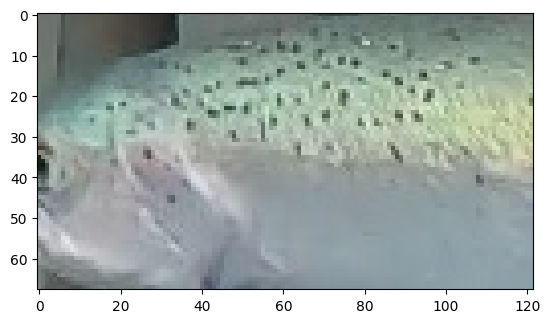

In [20]:
nr = 80
plt.imshow(err_img[nr])
print('True class: ', err_pred[nr][1])
print('Predicted class: ', err_pred[nr][0])